In [56]:
!python --version

Python 3.10.0


## Imports

In [85]:
import os 
import re
import string
import numpy as np
import spacy as sp
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

## Carregando os dados

In [58]:
dataset_path = 'dataset/'
dataset_name = 'dataset.csv'

dataset = pd.read_csv(os.path.join(dataset_path, dataset_name))
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público"
518,Empresas e órgãos públicos,orgão público
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público


## Exploratória

In [59]:
texto = 'sentence'
setor = 'category'

dataset[texto].sample(5).tolist()

['Na EAD Educação a distância você tem autonomia para organizar os seus estudos.',
 'Faça vestibular e estude EAD ou transferência na segunda graduação e volte a estudar.',
 'Monitoramos constantemente a segurança e eficácia dos nossos produtos. Relate os eventos adversos ocorridos com o uso de nossos produtos\u200b.',
 'Lojas de sapatos.',
 'Novo Nissan Versa, conheça o design e suas características no showroom virtual.']

In [60]:
dataset[setor].value_counts()

category
orgão público               140
educação                    107
indústrias                   89
varejo                       85
finanças                     54
finanças,varejo              13
educação,orgão público        9
indústrias,varejo             7
educação,indústrias           5
finanças,orgão público        4
finanças,indústrias           3
indústrias,orgão público      2
educação,finanças             2
varejo,indústrias             1
Name: count, dtype: int64

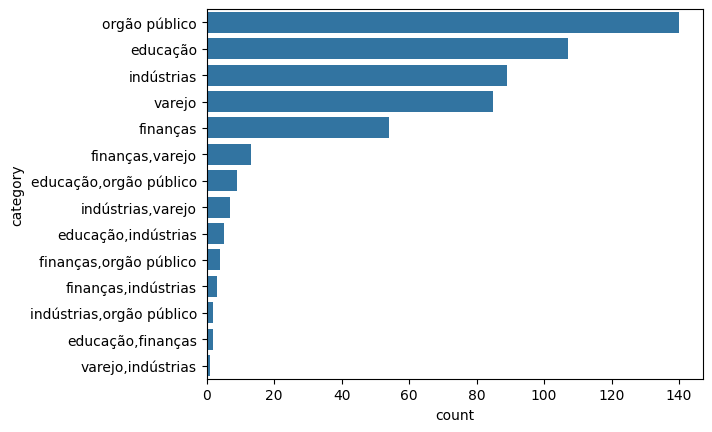

In [61]:
ordenados = dataset[setor].value_counts().index
sns.countplot(dataset[setor], order=ordenados);

Observando a frequência com que os setores são atribuídos aos textos, fica claro que o 'multi-labeling' não é tão presente, ou seja,
existem bem mais textos classificados à apenas um setor. 

Nesse momento, é importante decidir qual será a abordagem da modelagem. A priori, tendo a acreditar que modelar um multi-label não vá ser eficiente dado esse 'desbalanceamento'.

Uma alternativa é associar cada texto à um único setor.
- **E aqueles que são associados a dois setores?**

    Estes serão duplicados e associados aos dois setores. 
    
    Exemplo:
    
     'ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS EM VALPARAÍSO.' -> 'educação'   
     'ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS EM VALPARAÍSO.' -> 'orgão público'

    Assim, quando o modelo receber um input que se referir tanto ao setor 'educação' quanto ao setor 'orgão público', ele tenderá a dar pesos mais altos para essas duas classes. 

- **O modelo não vai ficar confuso tendo duas labels para o mesmo texto?**

    Essa abordagem de fato pode atrapalhar o aprendizado do modelo e diminuir a acurácia, no entanto, parte-se do pressuposto de que o modelo tenderá a atribuir maiores pesos para os textos relacionados à um setor em específico.

## Duplicando os textos com mais de um setor atribuído


In [62]:
## A label com dois setor está assumindo o tipo 'string' única, precisamos fazer com que seja uma lista com duas strings
dataset[setor] = [set.split(',') for set in dataset[setor]]
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",[orgão público]
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",[finanças]
2,Então encontraremos na próxima aula.,[educação]
3,Veja os resultados da categoria de ofertas do ...,[indústrias]
4,"Além disso, a embalagem é reutilizável e 100% ...","[indústrias, varejo]"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",[educação]
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"[educação, orgão público]"
518,Empresas e órgãos públicos,[orgão público]
519,DGE – Departamento de Gestão Estratégica Metas...,[orgão público]


In [63]:
## Duplicando as linhas e reiniciando o index
dataset = dataset.explode(setor).reset_index(drop=True)
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...",indústrias
...,...,...
562,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,educação
563,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,orgão público
564,Empresas e órgãos públicos,orgão público
565,DGE – Departamento de Gestão Estratégica Metas...,orgão público


## Tratamento dos textos

Uma vez com o dataset de textos e labels, é necessário fazer o tratamento dos textos para tornar o aprendizado do modelo mais eficiente. Para isso, é comum fazer a remoção de caracteres especiais e pontuações, assim como a  realização da tokenização (processo que divide o texto em unidades menores [palavras ou subpalavras]). Além disso, tambem devemos converter o texto para letras minúsculas para garantir consistência na contagem de palavras.

- Remover a acentuação.
- Remover caracteres especiais.
- Remover as 'stop words' que são palavras normalmente encaradas como 'ruído' no texto. 

Isso é importante para reduzirmos a dimensão de features e facilitar a identificação de padrões mais relevantes.

In [64]:
## Definindo stop words 
nlp = sp.blank("pt")
stop_words = sp.lang.pt.STOP_WORDS
[sw for sw in stop_words][:10]

['e',
 'onde',
 'oitava',
 'tanta',
 'a',
 'sob',
 'contudo',
 'foste',
 'grandes',
 'ora']

In [65]:
## Caracteres especiais
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
## Usando re (Regular Expression)
exemplo = 'Ele gosta de caçar'
re.sub(r"[ç]", "c", exemplo)  #Removendo o 'ç'

'Ele gosta de cacar'

In [67]:
def cleaning(text):
    text = text.lower()

    text = re.sub(r"[!@#%&$*º“”—-]", "", text)
    text = re.sub(r"[àáâãäåã]", "a", text)
    text = re.sub(r"[èéêë]", "e", text)
    text = re.sub(r"[ìíîï]", "i", text)
    text = re.sub(r"[òóôõö]", "o", text)
    text = re.sub(r"[ùúûü]", "u", text)
    text = re.sub(r"[ýÿ]", "y", text)
    text = re.sub(r"[ç]", "c", text)
    text = re.sub(r"[0-9]", "", text)

    text = text.lower()
    document = nlp(text)

    words = []
    for token in document:
        words.append(token.text)

    words = [word for word in words if word not in stop_words and word not in string.punctuation] 
    words = ' '.join([str(element) for element in words])

    return words

In [68]:
## Comparando texto original com o texto processado
for text in dataset[texto].sample(5).tolist():
    print(text)
    print(cleaning(text))
    print('\n')

Todo correntista do ITAÚ já possui uma conta poupança pronta para iniciar.
correntista itau ja possui conta poupanca pronta


Monte o seu carro Nivus conforme o seu gosto.
monte carro nivus conforme gosto


Pensão por Morte (Art. 74/9), Benefícios em Espécie, DIREITO PREVIDENCIÁRIO
pensao morte art. beneficios especie direito previdenciario


Registros e controles da qualidade, e sistema da qualidade que são os nossos processos.
registros controles qualidade qualidade sao processos


EM CONDIÇÕES PARTICULARES, QUAL O INTERVALO RECOMENDADO DE TROCA DO ÓLEO DO MOTOR?
condicoes particulares intervalo recomendado troca oleo motor




In [69]:
dataset[texto] = [cleaning(text) for text in dataset[texto]]
dataset[setor] = [cleaning(text) for text in dataset[setor]]

dataset

,sentence,category
0,auxiliodoenca previdenciario beneficios especi...,orgao publico
1,pagar contas atraso r.,financas
2,entao encontraremos proxima aula,educacao
3,resultados categoria ofertas modelo nissan kicks,industrias
4,alem embalagem reutilizavel reciclavel,industrias
...,...,...
562,estudantes rede municipal voltam aulas valparaiso,educacao
563,estudantes rede municipal voltam aulas valparaiso,orgao publico
564,empresas orgaos publicos,orgao publico
565,dge – departamento gestao estrategica metas na...,orgao publico


#### Tokenização

Antes da tokenização, vamos definir X como os textos e y sendo a representação númerica de cada setor (aplicando o label enconding)

In [70]:
X = dataset[texto]

enc = LabelEncoder()
y = enc.fit_transform(dataset[setor])

In [71]:
print('X >>\n',X[:5])
print('-----')
print('y >>',y[:5])

X >>
 0    auxiliodoenca previdenciario beneficios especi...
1                               pagar contas atraso r.
2                     entao encontraremos proxima aula
3     resultados categoria ofertas modelo nissan kicks
4             alem embalagem reutilizavel   reciclavel
Name: sentence, dtype: object
-----
y >> [3 1 0 2 2]


In [72]:
## Construindo o tokenizer (tendo 10 mil como o tamanho do vocabulario alvo)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X, target_vocab_size=10000)

In [73]:
## Tamanho do vocabulário
tokenizer.vocab_size

2233

In [74]:
tokenizer.subwords[:5]

['   ', 'voce_', 'carro_', 'x_', 'sao_']

Exemplo de como funciona a tokenização:

In [75]:
ids = tokenizer.encode('Aprenda LIBRAS')
ids

[2042, 2089, 116, 2053, 2050, 2043, 2059, 2042, 2060]

In [76]:
text = tokenizer.decode(ids)
text

'Aprenda LIBRAS'

___

In [77]:
data_inputs = [tokenizer.encode(sentence) for sentence in X]
data_inputs[:5]

[[616, 208, 103, 92, 27, 123],
 [77, 263, 1836, 2091, 2023],
 [536, 1508, 121, 284],
 [196, 595, 25, 1149, 7, 467],
 [104, 145, 114, 1, 370]]

#### Padding

Uma vez que muitos modelos exigem que o dado de entrada sejam de uma dimensão em específico, vamos aplicar o padding para que todos os inputs sejam do mesmo tamanho. 

In [78]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=30)

In [79]:
data_inputs[:2]

array([[ 616,  208,  103,   92,   27,  123,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [  77,  263, 1836, 2091, 2023,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])

## Modelagem

Como um primeiro modelo, optei criar uma Rede Neural Convolucional (CNN) que receberá os textos no formato `data_inputs`. Essa CNN processará o texto ao longo de camadas de convolução e pooling e, por fim, retornará a probabilidade do texto de entrada estar associado a cada classe possível.

Primeiro é necessário separar os dados de treino e os dados de teste.

In [83]:
data_labels = np.array(y)
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.1,
                                                                        stratify = data_labels)

In [26]:
print('Shape dos dados de treinamento:',f'Inputs: {train_inputs.shape} Labels: {train_labels.shape}')
print('Shape dos dados de teste:',f'Inputs: {test_inputs.shape} Labels: {test_labels.shape}')

Shape dos dados de treinamento: Inputs: (510, 30) Labels: (510,)
Shape dos dados de teste: Inputs: (57, 30) Labels: (57,)


Criando o modelo

Iniciando o Treinamento 

In [27]:
def DCNN(vocab_size,
         emb_dim=128,
         nb_filters=50,
         ffn_units=512,
         nb_classes=2,
         dropout_rate=0.1,
         training=False,
         name='dcnn'):

    # Definindo a entrada do modelo
    inputs = tf.keras.Input(shape=(None,), name='input_text')

    # Camada de embeddings
    x = tf.keras.layers.Embedding(vocab_size, emb_dim)(inputs)

    # Convoluções de Bigrama seguidas por pooling
    conv1 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')(x)
    conv1 = tf.keras.layers.GlobalMaxPool1D()(conv1)

    # Convoluções de Trigrama seguidas por pooling
    conv2 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')(x)
    conv2 = tf.keras.layers.GlobalMaxPool1D()(conv2)

    # Convoluções de Trigrama seguidas por pooling
    conv3 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.GlobalMaxPool1D()(conv3)

    # Convoluções de Quatrigrama seguidas por pooling
    conv4 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')(x)
    conv4 = tf.keras.layers.GlobalMaxPool1D()(conv4)

    # Convoluções de Quatrigrama seguidas por pooling
    conv5 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')(x)
    conv5 = tf.keras.layers.GlobalMaxPool1D()(conv5)

    # Concatenando as saídas das convoluções
    merged = tf.keras.layers.concatenate([conv1, conv2, conv3, conv4, conv5], axis=-1)

    # Rede densa
    dense = tf.keras.layers.Dense(units=ffn_units, activation='relu')(merged) # Camada densa inicial
    dropout = tf.keras.layers.Dropout(rate=dropout_rate)(dense, training=training) # Camada de dropout
    
    # Camada de saída
    if nb_classes == 2:
        outputs = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output')(dropout)
    else:
        outputs = tf.keras.layers.Dense(units=nb_classes, activation='softmax', name='output')(dropout)

    # Criando o modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

    return model

Escolhendo valores para os parâmetros do modelo

In [28]:
## Parametros
vocab_size = tokenizer.vocab_size
emb_dim = 128
nb_filters = 100
ffn_units = 512
batch_size = 32
nb_classes = len(set(train_labels))
dropout_rate = 0.2
nb_epochs = 100

In [29]:
## Inicializando modelo
model = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [30]:
## Compilando
if nb_classes == 2:
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
else:
  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Treinamento considerando 10% dos dados para validação

In [31]:
history = model.fit(train_inputs, train_labels,
            batch_size = batch_size,
            epochs = nb_epochs,
            verbose = 1,
            validation_split = .1)

results = model.evaluate(test_inputs, test_labels, batch_size=batch_size)
print('loss: ',results[0],'\nacurácia: ',results[1])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2388 - loss: 1.6044 - val_accuracy: 0.2941 - val_loss: 1.5915
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3224 - loss: 1.5273 - val_accuracy: 0.2745 - val_loss: 1.5424
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5460 - loss: 1.3236 - val_accuracy: 0.5294 - val_loss: 1.3817
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8128 - loss: 0.8655 - val_accuracy: 0.5686 - val_loss: 1.2650
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9295 - loss: 0.3287 - val_accuracy: 0.6078 - val_loss: 1.4138
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9350 - loss: 0.1869 - val_accuracy: 0.5882 - val_loss: 1.6237
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9118 - loss: 0.2452 - val_accuracy: 0.6078 - val_loss: 1.3936
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9307 - loss: 0.1428 - val_accuracy: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9120 - loss: 0.1411 - val_accuracy: 0.6667 - val_loss: 1.6534
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9384 - loss: 0.1116 - val_accuracy: 0.6667 - val_loss: 1.5775
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9406 - loss: 0.0980 - val_accuracy: 0.6863 - val_loss: 1.6282
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8961 - loss: 0.1307 - val_accuracy: 0.6863 - val_loss: 1.6264
Epoch 28/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9079 - loss: 0.1283 - val_accuracy: 0.6667 - val_loss: 1.6469
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9221 - loss: 0.1142 - val_accuracy: 0.6471 - val_loss: 1.6620
Epoch 30/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9448 - loss: 0.1072 - val_accuracy: 0.6667 - val_loss: 1.6570
Epoch 31/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9163 - loss: 0.1271 - val_accuracy: 0.6667 

In [93]:
## Salvando o modelo 
model.save('CNNModel.h5')
del model
model = load_model("CNNModel.h5")

#### Avaliação do modelo

In [111]:
confusion_matrix(test_labels, y_pred_test)

array([[18,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0],
       [ 1,  1,  8,  1,  0],
       [ 2,  0,  0, 11,  0],
       [ 0,  1,  2,  0,  6]], dtype=int64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


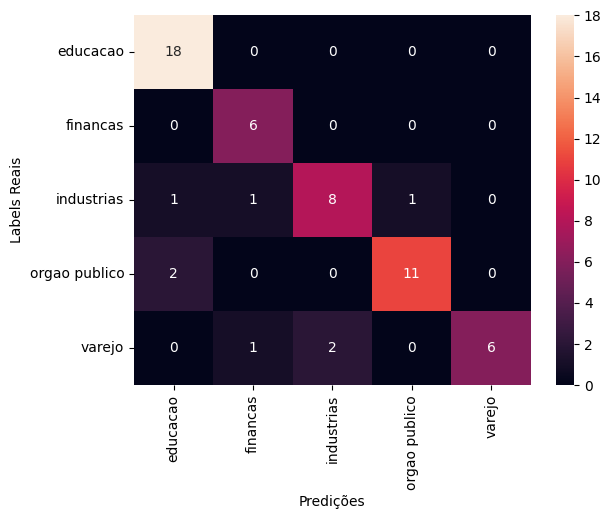

In [100]:
y_pred_test = [np.argmax(y_pred_test) for y_pred_test in model.predict(test_inputs)]
cm = confusion_matrix(test_labels, y_pred_test)

# Definindo os rótulos das classes
classes = [enc.inverse_transform([i])[0] for i in range(5)]

# Plot do heatmap
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)

# Definindo os rótulos dos eixos
plt.xlabel('Predições')
plt.ylabel('Labels Reais')

# Mostrando o gráfico
plt.show()

Com a matriz de confusão, observamos que o modelo foi bem principalmente para os setores (Educação, Orgão Público e Indústrias). É um resultado esperado, dado que são essas classes as predominantes do conjunto de dados.

A matriz de confusão assimétrica, reflete justamente o já comentado desbalanceamento dos dados.

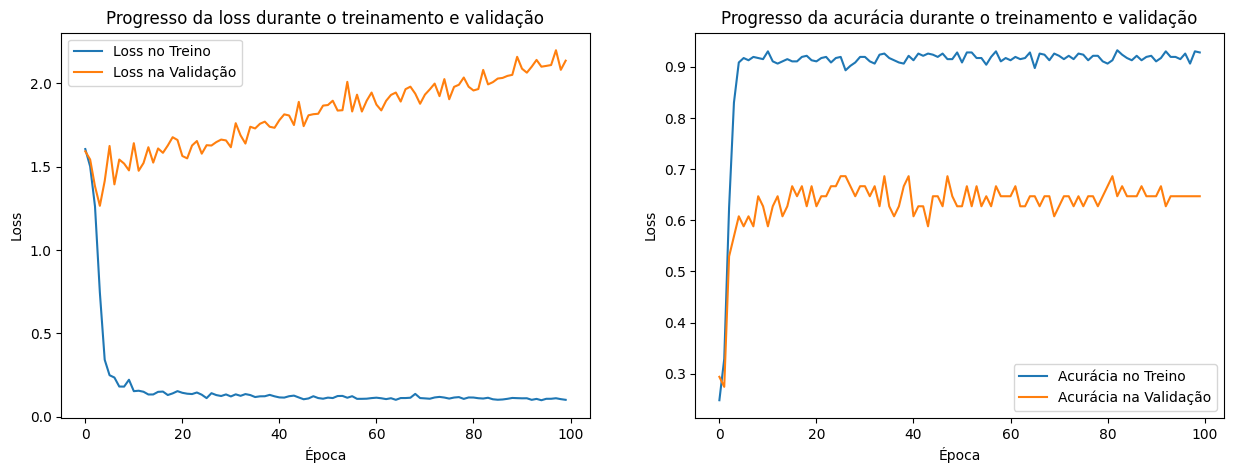

In [95]:
# Define o tamanho da figura
plt.figure(figsize=(15, 5))

# Primeiro subplot para loss
plt.subplot(1, 2, 1)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Progresso da loss durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(['Loss no Treino', 'Loss na Validação'])

# Segundo subplot para accuracy
plt.subplot(1, 2, 2)  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Progresso da acurácia durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(['Acurácia no Treino', 'Acurácia na Validação']);

(Baseado na validação)
Com base nos plots, vemos que o modelo não foi tão eficiente no aprendizado, apresentando uma curva ascendente de Loss. No entanto, a acurácia foi razoavelmente bem acertando em média 60% das predições. 

## Predizendo input

In [96]:
def predict_sector(text: object = 'Texto com o tema de interesse', threashold: float = 0.2) -> list:
    # Tokeniza o texto usando o tokenizador
    text = tokenizer.encode(text)
    
    # Faz a previsão usando o modelo
    list_of_predictions = model.predict(np.array([text]))
    
    # Encontra os índices das previsões que têm uma probabilidade acima do threashold especificado
    ind = []
    for i in range(len(list_of_predictions)):
        ind.append(np.where(list_of_predictions[i] > threashold)[0].tolist())
        
    lab = []
    # Converte os índices das previsões em rótulos
    for i in ind:
        # Se houver mais de um índice com probabilidade acima do limiar
        if len(i)>1:
            aux = []
            # Converte cada índice em seu rótulo correspondente
            for j in i:
                aux.append(enc.inverse_transform([j]).tolist()[0])
            lab.append(aux)
        # Se houver apenas um índice com probabilidade acima do limiar
        else:
            lab.append(enc.inverse_transform(i).tolist()[0])
        
    return lab

Exemplos

In [97]:
predict_sector('No cartao com juros!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[['financas', 'varejo']]

In [98]:
predict_sector('Faça curso de LIBRAS.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


['educacao']

In [99]:
predict_sector('As peças do carro quebraram.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


['industrias']